# Task 3 - Learning from the present to fill in gaps in the past

The task should:

* Exploit data from two sources (e.g. large scale gridded analysis and in situ observations) – clearly articulating their provenance.

* Apply both supervised (e.g. discrimination, classification, or other supervised ML) and unsupervised (e.g. PCAs, Cluster analysis, or other unsupervised ML)  statistical techniques in some way in a clear,  transparent and reproducible way.

* Clear and illuminating text (approx. 2000 words) including appropriate references and 4-5 figures outlining the environmental challenge and demonstrating the insights of the statistical techniques.

What I have done (and will do):

* use hourly rain gauge data and enteroccoci data to try and fill in gaps of enteroccoci sampling

* hourly rain data instead of individual rain gauges use an area average from Concord, Gladesville and Lilyfield. These contain the least missing entries so gives fullest data and is good amount of area

* align enteroccoci and rain data to get previous 24 and 48 hour totals of rain **from the time the sample was taken**. It may be the case that these have to change as otherwise how can they match unless they happened to be sampled at the same time?

* form PC model of time series at Dawn Fraser pool

* try to use Dawn Fraser model to fill in gaps at other sites in the area

* fill in rain data then somehow do something else?

The challenge being looked at is how quick is recovery after rain and can predictions of enteroccoci be made to help forecast when swim sites will be shut.
This could also be reframed as deciding how much rain is needed in a 48 hour period prior to a morning to shut a pool.
That would mean would do what I have done, then perform some sort of discrimanant analysis so that the enterococci is grouped by amount and determine how much rain in a 48 hour period causes this.
Then could check this against thresholds that they have.

The problem could be posed: how much rainfall in a 48 hour period prior causes the pool to have high probability.

In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [113]:
using DataFrames, CSV, Dates, Plots, Statistics, LinearAlgebra, GLM, CategoricalArrays

## Rain gauge data

The rain gauge data is collected from seven Sydney Water climate stations along the Parramatta River catchment.
The location of the rain gauges for Homebush, Concord, Ashfield, West Ryde and Gladesville are shows on the image below as rain clouds.
Lilyfield and fivedock rain gauges are not part of this collection and are not shown but will be somewhere in the area as indicated on the image.
 
<img src="swimsites.png" width=500 height=300>

The rain records are for the period 01/01/1996 - 04/04/2021 with readings taken every hour in millimetres.
The hourly rain records from some sites have many missing entries.
The long periods of missing data are due to stations being closed, and opened or from the upgrading/downgrading of a station to a full weather station or rainfall only station.

The total number of observations for this period is 225716.
From the summary table below three rain gauages (Homebush, Fivedock and Ashfield) are missing over half the observations during this period.
So many missing entries is likely the cause of damaged instrumentation (perhaps not the actual rain gauge but another part of the weather facility) or as mentioned above the stations being opend/closed, upgraded/downgraded.

In contrast three rain gauges have less than 3087 (Concord, Lilyfield and Gladesville) missing entries over this period.
We now read in this data and describe it further.

In [3]:
#Read in the rain data
data_path = joinpath("../..", "Riverwatch/Data/raw")
rain_path = joinpath(data_path, "rain_hourly.csv")
rain_data = CSV.File(rain_path)
rain = DataFrame(rain_data)

#Convert the strings into DateTime format and form a new dataframe
date_format = Dates.DateFormat("d/m/Y")
new_dates = parse.(Date, rain[:, :date], date_format)
find = findfirst(new_dates .== Date(0000, 01, 01))
new_dates[1:find-1] .+= Year(1900)
new_dates[find:end] .+= Year(2000)
datetime = @. new_dates + rain[:, :time] 
rain =  rain[!, Not([:date, :time])]
insertcols!(rain, 1, :datetime => datetime)
first(rain, 5)

5×8 DataFrame
 Row │ datetime             Homebush  WestRyde  Concord   Lilyfield  Fivedock  ⋯
     │ DateTime             Float64?  Float64?  Float64?  Float64?   Float64?  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1996-01-01T00:00:00       0.0       0.0       0.0        0.0       0.0  ⋯
   2 │ 1996-01-01T01:00:00       0.0       0.0       0.0        0.0       0.0
   3 │ 1996-01-01T02:00:00       0.0       0.0       0.0        0.0       0.0
   4 │ 1996-01-01T03:00:00       0.0       0.0       0.0        0.0       0.0
   5 │ 1996-01-01T04:00:00       0.0       0.0       0.0        0.0       0.0  ⋯
                                                               2 columns omitted

The `rain` dataframe contains the hourly rain gauage data from all seven rain gauge.
We now summarise this data.

In [4]:
describe(rain)

8×7 DataFrame
 Row │ variable     mean      min                  median  max                 ⋯
     │ Symbol       Union…    Any                  Union…  Any                 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime               1996-01-01T00:00:00          2021-04-01T01:00:00 ⋯
   2 │ Homebush     0.111786  0.0                  0.0     77.0
   3 │ WestRyde     0.117512  0.0                  0.0     50.5
   4 │ Concord      0.105908  0.0                  0.0     46.5
   5 │ Lilyfield    0.122417  0.0                  0.0     56.0                ⋯
   6 │ Fivedock     0.129592  0.0                  0.0     46.5
   7 │ Gladesville  0.113492  0.0                  0.0     53.5
   8 │ Ashfield     0.128189  0.0                  0.0     62.0
                                                               2 columns omitted

We can see the mean rainfall over the time period is reasonably similar (as we would expect with the rain gauges being close to each other) ranging from 0.11 (2 decimal places) at Concord to 0.13 (2 decimal places) at Ashfield and Fivedock.
Ashfield and Fivedock are two of the gauges with many missing entries so it may be that this higher value is related to when the missing values occur, though with it only being a little higher it is not an issue.

The maximum rainfall at each station suggests there are no apparent outliers, though the maximum value at Homebush being 17mm higher than the next highest maximum is curious.
Further investigation of the readings at the other rain gauges is requried to see if this is just a particularly intense hour of rain or an error.
There are no negative records so on the whole the data that has been collected seems to be of good quality.
The summary reveals there are many missing values at Homebush, Fivedock and Ashfield.
Likely explanations for this are given above.

As well as individual rain gauge data the area average is of interest.
This is the average rainfall for each hour of at the rain gauges.
Whilst this data is more coarse than the readings from an individual gauage, it allows are more complete dataset to be formed.
This is important for use with the bacteria data where there are far less records.

To get an average rainfall for the region we take the average of all the missing entries of the hourly observations across the seven rain gauges.
This may introduce some error if all seven rain gauges have a missing entry as such a case will be assigned zero.
To check if there are any occurances of this we make a count.

In [5]:
area_av_rain = Array{Float64}(undef, length(rain[:, :datetime]))
count = 0
for i in 1:length(rain[:, :datetime])
    
    temp = rain[i, 2:end]
    area_av_rain[i] = mean(skipmissing(temp))

    countmissing = 0
    for j in 1:length(temp)
        if ismissing(temp[j]) == true
            countmissing += 1
        end
    end

    if countmissing == length(temp)
        count += 1
    end
end
println("Number of gauges with all missing entries is "*string(count))

Number of gauges with all missing entries is 0


There is no occurance of this so we will use the area average rainfall (`area_av_rain`) for our rain data.
It is likely that some of the entries are just from one gauge which is not ideal as there is no average, but for the purposes we are using it for this is preferential to missing entries.
The time series for the rain data is plotted below.
Then we make a new dataframe for this average rain data and summarise it with statistics.

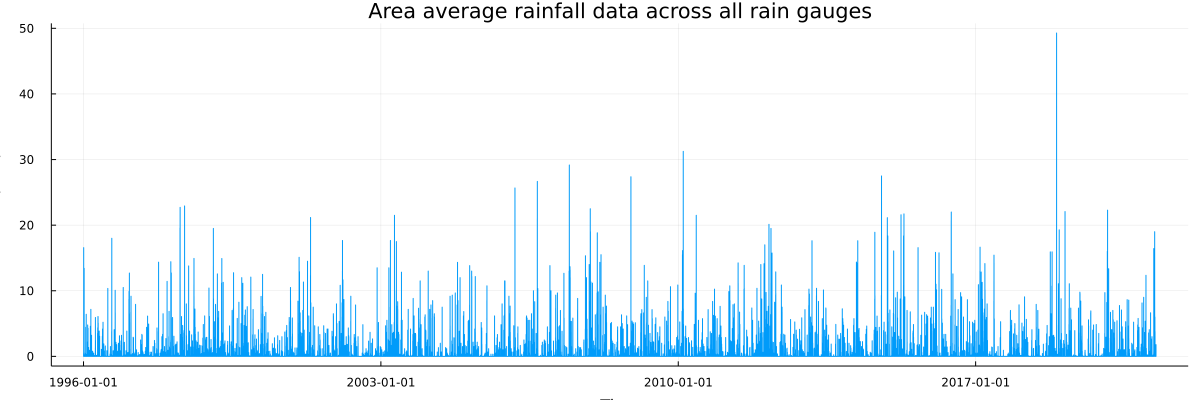

In [6]:
plot(rain[:, :datetime], area_av_rain, size = (1200, 400), label = false, xlabel = "Time", ylabel = "Rain (mm)", title = "Area average rainfall data across all rain gauges")

In [7]:
df_area_av = DataFrame(datetime = datetime, area_av = area_av_rain)
describe(df_area_av)

2×7 DataFrame
 Row │ variable  mean      min                  median  max                  n ⋯
     │ Symbol    Union…    Any                  Union…  Any                  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime            1996-01-01T00:00:00          2021-04-01T01:00:00    ⋯
   2 │ area_av   0.115383  0.0                  0.0     49.2857
                                                               2 columns omitted

Again we have no negative rainfall recorded.
The maximum hourly area average rainfall recorded is 49.3mm which again suggests the data is of high quality as there are no extreme values in the area average.
The mean of the area average rainfall is 0.12 which looks to be reasonable based on the mean rainfall recorded at each location.

**Group the rain data here?** Might be a nice application of one of the classification techniques.

## Bacteria data

The bacteria data are samples taken at swimming sites are measurements of the amount of a bacteria called enterococci in the water.
The enterococci is measured by the number of colonies forming per 100mL of water sampled (cfu/100mL).
Enerococci is a bacteria found in the faecal matter of warm blooded animals and is rarely recorded in clean water.
The presence of enterococci in water samples is the recommended indicator organism of faecal pollution ([Guidelines for Managing Risks in Recreational Water](https://www.nhmrc.gov.au/about-us/publications/guidelines-managing-risks-recreational-water)).
Enterococci is not harmful to swimmers, however higher levels on enterococci found in samples correspond to higher levels of sewage polution in the water which has been linked to illness in swimmers.[2]

The samples of enterococci are recorded between 1994-2021.
Samples are recorded every six days during the swimming season (October - April) and monthly during the off season for swimming (May - September).
The time the sample is taken is not the same each day.
In this project we look at the enterococci recorded at three swim sites, these are:

* Dawn Fraser pool

* Chiswick baths

* Cabarita beach.

For the purposes of classifying the level of enterococci the following groups are used by [Beachwatch](https://www.environment.nsw.gov.au/topics/water/beaches/monitoring-beach-water-quality):

1. 0-40 cfu/100mL

2. 41-200 cfu/100mL

3. Greater than 201 cfu/100mL.

These groups are not part of the data set so are added manually below.

Rainfall causes stormwater to flow into waterways and this can carry sewage (in small amounts) into the water.
This is how the rainfall is related to the amount of enterococci in the waterways.

The less frequent sampling of the bacteria means that there is more oppourunity to fill in gaps in past data, though what is of interest here is how to decide if a swim site has too much pollutant to allow swimming based on rainfall.

To look at how rainfall could be used to model and predict the amount of enterococci the data must first be matched.
This is done by finding the time each sample is taken at and calculating the previous 48 hour rainfall in mm.
The previous 48 hour rainfall is chosen because it gives a longer window of enterococci be measured.

### Bacteria data

In [125]:
#Read in the data
ent_path = joinpath(data_path, "ent_routine.csv")
ent_data = CSV.File(ent_path)
ent = DataFrame(ent_data)

#Convert Strings into DateTime format
new_dates = parse.(Date, ent[:, :Date], date_format)
datetime = @. new_dates + ent[:, :time] 
datetime = round.(datetime, Dates.Hour)
ent =  ent[!, Not([:Date, :time, :Nearest_hr])]
insertcols!(ent, 1, :datetime => datetime)
insertcols!(ent, 1, :date => new_dates)

#Find relevant locations
find = findall(ent[:, :location] .== "Dawn Fraser Pool") 
append!(find, findall(ent[:, :location] .== "Cabarita Beach"))
append!(find, findall(ent[:, :location] .== "Chiswick Baths"))
ent = ent[find, :]

#Classify the Enteroccoci observations into groups
group = Array{String}(undef, length(ent[:, :datetime]))
groupvals = [40, 200]
for i in 1:length(ent[:, :datetime])
    if ent[i, :ent] <= groupvals[1]
        group[i] = "A"
    elseif ent[i, :ent] > groupvals[2]
        group[i] = "C"
    else
        group[i] = "B"
    end
end
group = CategoricalArray(group)
insertcols!(ent, 5, :group => group)
first(ent, 5)

5×5 DataFrame
 Row │ date        datetime             location          ent      group 
     │ Date        DateTime             String31          Float64  Cat…  
─────┼───────────────────────────────────────────────────────────────────
   1 │ 1994-10-05  1994-10-05T10:00:00  Dawn Fraser Pool      1.0  A
   2 │ 1994-10-11  1994-10-11T11:00:00  Dawn Fraser Pool      0.0  A
   3 │ 1994-10-17  1994-10-17T11:00:00  Dawn Fraser Pool     41.0  B
   4 │ 1994-10-22  1994-10-22T09:00:00  Dawn Fraser Pool     79.0  B
   5 │ 1994-10-29  1994-10-29T09:00:00  Dawn Fraser Pool      1.0  A

## Match rain and bacteria data

The rain data to 9am could be used though here we are going to round the bacteria collection time to the nearest hour then match that to a rain date/time and find the previous 48 hour rainfall.

We will then look to model the enterococi using the previous 48 hour rainfall.

First we remove dates that do not cross over between the bacteria and rain data.
Then match up date and time of bacteria sample to a rain date and time and sum the previous 48 entries.
We also find the anomalies for the previous 48 hour rainfall and enterococci.

In [115]:
find = findall(ent[:, :datetime] .< rain[1, :datetime])
delete!(ent, find)
find = findall(ent[:, :datetime] .> rain[end, :datetime])
delete!(ent, find);

rain_48 = Array{Float64}(undef, length(ent[:, :datetime]))

for i in 1:length(ent[:, :datetime])
    
    match = findall(ent[i, :datetime] .== df_area_av[:, :datetime])[1]
    rain_48[i] = sum(df_area_av[(match - 48):match, :area_av])
    
end

rain_48_mean = mean(skipmissing(rain_48))
ent_mean = mean(ent[:, :ent])
rain_48_anom = rain_48 .- rain_48_mean
ent_anom = ent[:, :ent] .- ent_mean;

Now we can form a data frame that has all the information from the rain and bacteria data in one.

In [116]:
ent_rain = DataFrame(date = ent[:, :date],
                    datetime = ent[:, :datetime], 
                    location = ent[:, :location], 
                    rain_48 = rain_48, 
                    rain_48_anom = rain_48_anom,
                    ent = ent[:, :ent],
                    group = ent[:, :group],
                    ent_anom = ent_anom)
describe(ent_rain)

8×7 DataFrame
 Row │ variable      mean          min                  median    max          ⋯
     │ Symbol        Union…        Any                  Union…    Any          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ date                        1996-01-05                     2021-03-31   ⋯
   2 │ datetime                    1996-01-05T09:00:00            2021-03-31T1
   3 │ location                    Cabarita Beach                 Dawn Fraser
   4 │ rain_48       5.90942       0.0                  0.214286  129.45
   5 │ rain_48_anom  -6.29432e-15  -5.90942             -5.69514  123.541      ⋯
   6 │ ent           148.638       0.0                  5.0       28000.0
   7 │ group                       A                              C
   8 │ ent_anom      -3.98355e-15  -148.638             -143.638  27851.4
                                                               3 columns omitted

## Dawn Fraser

Dawn Fraser pool has the most entries for `ent` so we take this and form a principal component model.
An instant simplifaction is that now instead of two rather large datasets now just have one PC model which is quite good.

First we extract only the Dawn Fraser pool data and take a look at what this looks like.

In [117]:
find = findall(ent_rain[:, :location] .== "Dawn Fraser Pool")
ent_rain_df = ent_rain[find, :]
first(ent_rain_df, 5)

5×8 DataFrame
 Row │ date        datetime             location          rain_48     rain_48_ ⋯
     │ Date        DateTime             String31          Float64     Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1996-01-05  1996-01-05T09:00:00  Dawn Fraser Pool   5.07143       -0.83 ⋯
   2 │ 1996-01-10  1996-01-10T13:00:00  Dawn Fraser Pool   0.0714286     -5.83
   3 │ 1996-01-16  1996-01-16T09:00:00  Dawn Fraser Pool   0.0           -5.90
   4 │ 1996-01-22  1996-01-22T12:00:00  Dawn Fraser Pool  12.3333         6.42
   5 │ 1996-01-28  1996-01-28T13:00:00  Dawn Fraser Pool   0.0           -5.90 ⋯
                                                               4 columns omitted

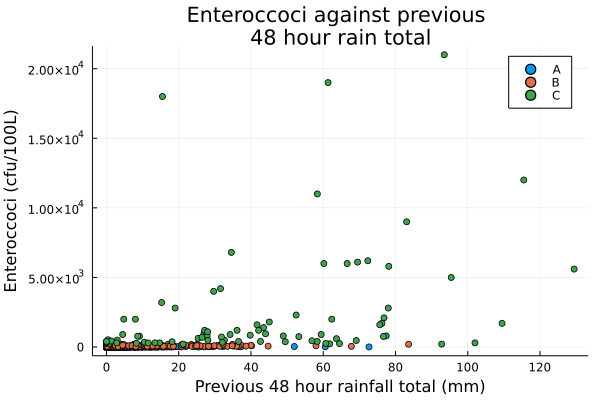

In [123]:
scatter_48 = scatter(ent_rain_df[:, :rain_48], ent_rain_df[:, :ent], group = ent_rain_df[:, :group],
                    xlabel = "Previous 48 hour rainfall total (mm)", 
                    ylabel = "Enteroccoci (cfu/100L)", 
                    title = "Enteroccoci against previous \n48 hour rain total")

In [37]:
ent_rain_df_mat = Matrix(ent_rain_df[:, [:rain_48_anom, :ent_anom]])
covmat = cov(ent_rain_df_mat)
λ, e = eigen(covmat)
sort!(λ, rev = true)
e1 = e[end]
e2 = e[1]

u1 = sum(ent_rain_df_mat * e1, dims = 2)
#u2 = sum(ent_rain_df_mat * e1, dims = 2)
recon = e1 .* u1;

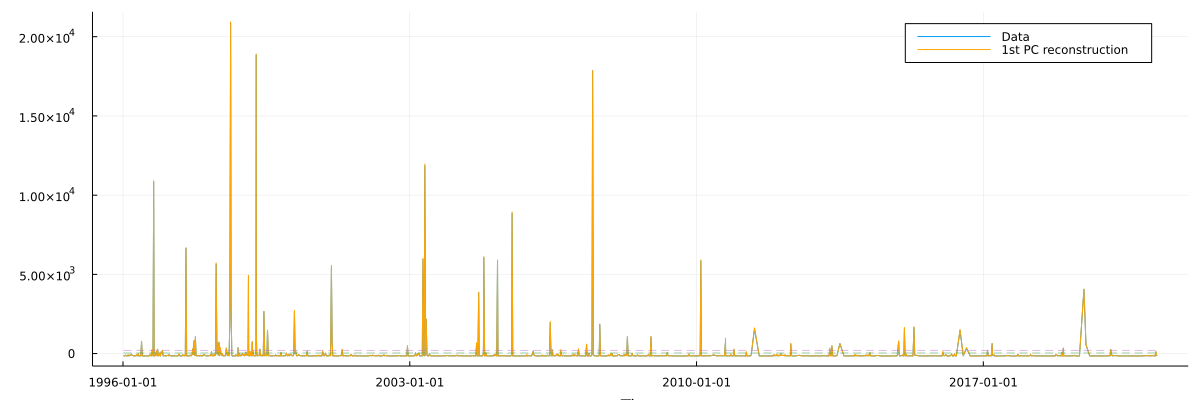

In [127]:
data_df_plot = plot(ent_rain_df[:, :datetime], ent_rain_df[:, :ent_anom], 
                    xlabel = "Time",
                    ylabel = "Enteroccoci",
                    label = "Data", 
                    size = (1200, 400))
plot!(data_df_plot, ent_rain_df[:, :datetime], recon, 
        xlabel = "Time",
        ylabel = "Enteroccoci",
        label = "1st PC reconstruction",
        size = (1200, 400), color = :orange)
plot!(data_df_plot, ent_rain_df[:, :datetime], groupvals[1] .* ones(length(ent_rain_df[:, :datetime])),
    line = (:dash, 0.5),
    label = false)
plot!(data_df_plot, ent_rain_df[:, :datetime], groupvals[2] .* ones(length(ent_rain_df[:, :datetime])),
    line = (:dash, 0.5),
    label = false)

From the plot above we can see the principal component reconstruction matches the data extremely well.
The total amount of variance captured by the reconstruction is given by

$$
    R_{1}^{2} = \frac{\lambda_{1}}{\sum_{i=1}^{2}\lambda_{i}}.
$$

where $\lambda_{i}$ is the $ith$ eigenvalue of the covariance matrix.
Calculating this we see

In [39]:
R2 = λ[1] / sum(λ)

0.9998874151781212

Hence the first principal component explains 0.9999% of the variance.
This explains how such an accurate reconstruction of the data is acheived with just one principal component.

Using the principal component $u_{1}$ we now build a principal component regression (PCR) model.
This is done by using the principal component $u_{1}$ as the predictor for the predictand, which is the enterococci anomaly.
The data is split into training data (75%) and test data (25%) so we have data to test the model on.

In [80]:
N = round(Int64, 3*length(ent_rain_df[:, :datetime]) / 4)

PCR_data = DataFrame(u1 = u1[1:N], y = ent_rain_df[1:N, :ent_anom])

fm = @formula(y ~ u1)
linfit = lm(fm, PCR_data)
a, b = coef(linfit)
println("Intercept = "*string(a)*"\nSlope = "*string(b))

Intercept = 0.23114507345460747
Slope = 0.9941329244125721


This now gives the linear model

$$
    \hat{y} = a + bu_{1}
$$

where $u_{1}$ is the first principal component and $a$, $b$ are the fitted coefficients printed above.
Using this model we can compare the true values to the predicted values.

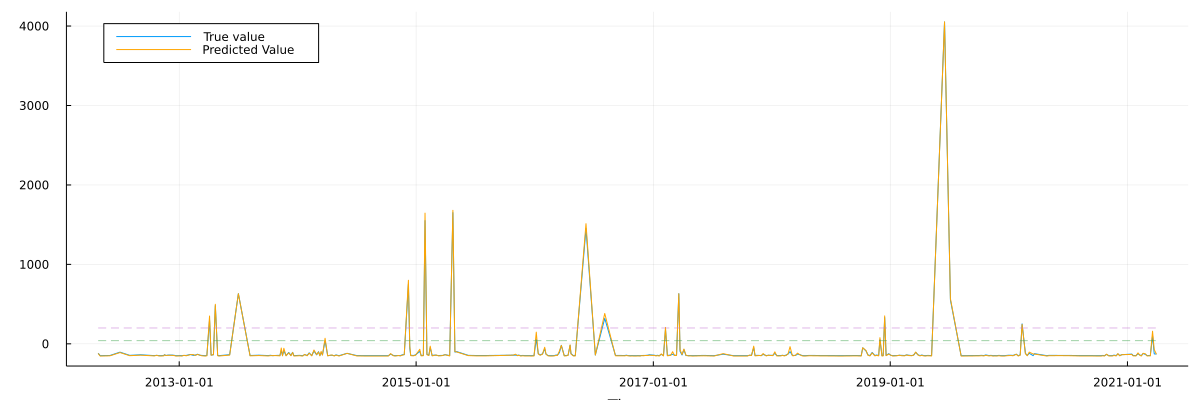

In [130]:
yhat = @. a + b * u1[N:end]

data_df_plot = plot(ent_rain_df[N:end, :datetime], ent_rain_df[N:end, :ent_anom], 
                    xlabel = "Time",
                    ylabel = "Enteroccoci",
                    label = "True value", 
                    size = (1200, 400), legend = :topleft)
plot!(data_df_plot, ent_rain_df[N:end, :datetime], yhat, 
    xlabel = "Time",
    ylabel = "Enteroccoci",
    label = "Predicted Value",
    size = (1200, 400), color = :orange)
plot!(data_df_plot, ent_rain_df[N:end, :datetime], groupvals[1] .* ones(length(ent_rain_df[N:end, :datetime])),
    line = (:dash, 0.5),
    label = false)
plot!(data_df_plot, ent_rain_df[N:end, :datetime], groupvals[2] .* ones(length(ent_rain_df[N:end, :datetime])),
    line = (:dash, 0.5),
    label = false)

The predicted values (orange) very closely match the data.
The $R^{2}$ value of 0.99999 indicates that nearly all of the variance is explained by the model.

Could compare this to a linear model and show why it is so good.

In [81]:
r2(linfit)

0.9999181780843095

### Chiswick baths

With the PCA model of Dawn Fraser pool can something be done to fill in gaps in the of the Chiswick baths data?
This does not work so well (or at all?).

In [25]:
find = findall(ent_rain[:, :location] .== "Chiswick Baths")
ent_rain_cb = ent_rain[find, :]
describe(ent_rain_cb)

7×7 DataFrame
 Row │ variable      mean       min                  median    max             ⋯
     │ Symbol        Union…     Any                  Union…    Any             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ date                     1999-03-01                     2021-03-31      ⋯
   2 │ datetime                 1999-03-01T12:00:00            2021-03-31T13:0
   3 │ location                 Chiswick Baths                 Chiswick Baths
   4 │ rain_48       5.83969    0.0                  0.166667  129.45
   5 │ rain_48_anom  -0.069733  -5.90942             -5.74276  123.541         ⋯
   6 │ ent           88.9954    0.0                  4.0       13000.0
   7 │ ent_anom      -59.6424   -148.638             -144.638  12851.4
                                                               3 columns omitted

Now want to match up dates for the when enterococci was recorded.
There are 17 dates in the Chiswick baths that are not in the Dawn Fraser pool so we remove these.
The dates that are matched are then used to form a regression model with the predictor being the principal component reconstruction of the enterococci data from Dawn Fraser.

I think that what is below is not aligned properly, need to check that everything is matched correctly but with this will have predictive model of time series based on ent measurements from Dawn Fraser.

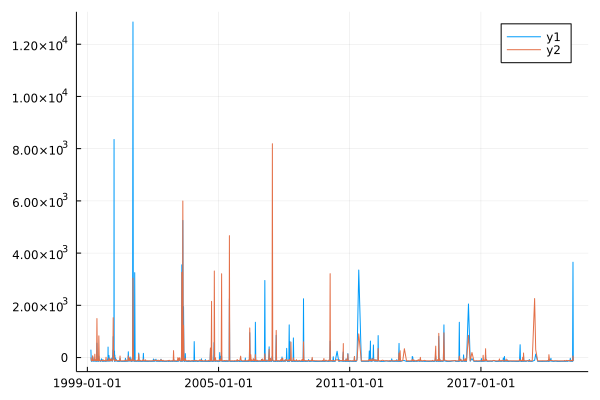

In [26]:
find = zeros(Int64, length(ent_rain_cb[:, :date]))

for i in 1:length(ent_rain_cb[:, :date])
    if isnothing(findfirst(ent_rain_cb[i, :date] .== ent_rain_df[:, :date])) == false
        find[i] = findall(ent_rain_cb[i, :date] .== ent_rain_df[:, :date])[1]
    end
end

remove_zero = findall(find .!= 0)
find = find[remove_zero]

x = recon[find]
X = [ones(length(find)) x x.^2 x.^3]
y = ent_rain_cb[:, :ent_anom][remove_zero]

linfit = X \ y
yhat = @. linfit[1] + linfit[2] * x + linfit[3] * x^2

plot(ent_rain_cb[:, :date], ent_rain_cb[:, :ent_anom])
plot!(ent_rain_cb[:, :date][remove_zero], yhat)

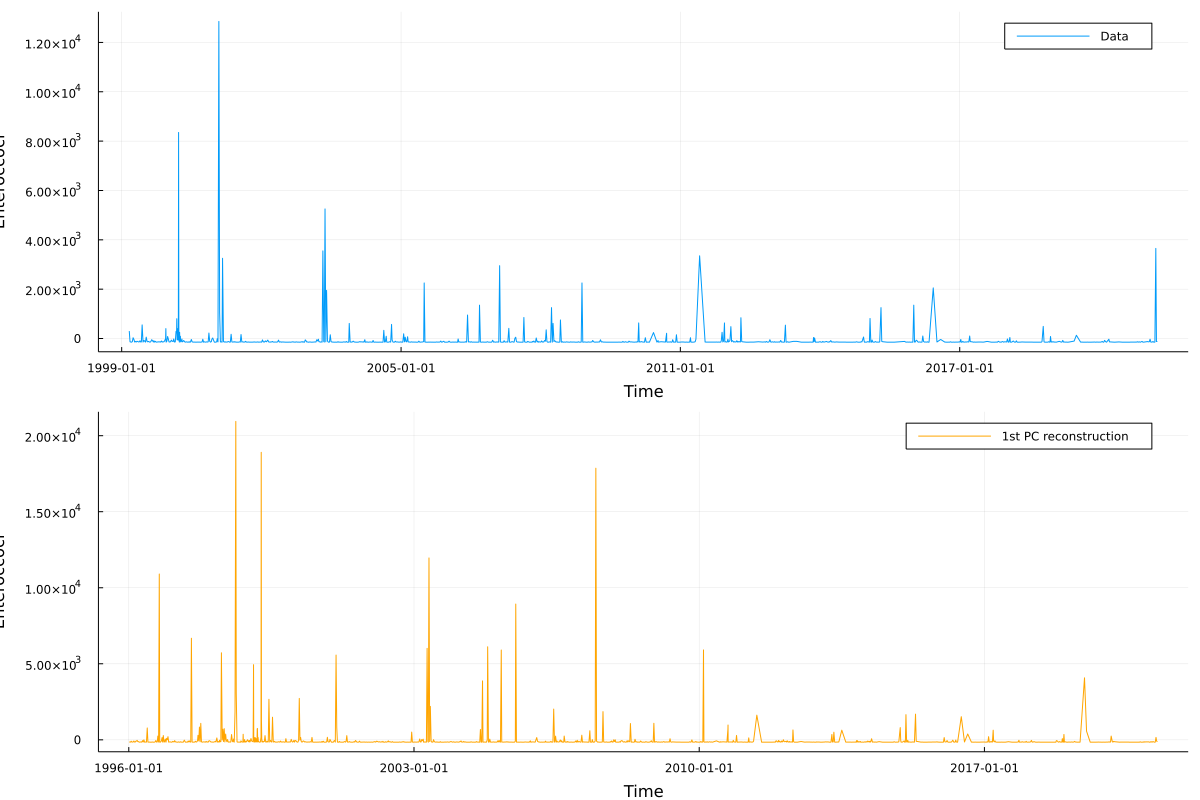

In [27]:
data_df_plot = plot(ent_rain_cb[:, :datetime], ent_rain_cb[:, :ent_anom], 
                    xlabel = "Time",
                    ylabel = "Enteroccoci",
                    label = "Data", 
                    size = (1200, 400))
recon_df_plot = plot(ent_rain_df[:, :datetime], recon, 
                    xlabel = "Time",
                    ylabel = "Enteroccoci",
                    label = "1st PC reconstruction",
                     size = (1200, 400), color = :orange)
plot(data_df_plot, recon_df_plot, size = (1200, 800), layout = (2, 1))

## Cabarita beach 

The eneterococci data do not match especially well between Chiswick baths and Dawn Fraser so I will look to do the same thing with Cabarita beach and see if anything comes from it.

In [28]:
find = findall(ent_rain[:, :location] .== "Cabarita Beach")
ent_rain_cbeach = ent_rain[find, :]
describe(ent_rain_cbeach)

7×7 DataFrame
 Row │ variable      mean        min                  median    max            ⋯
     │ Symbol        Union…      Any                  Union…    Any            ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ date                      1996-10-04                     2021-03-31     ⋯
   2 │ datetime                  1996-10-04T11:00:00            2021-03-31T13:
   3 │ location                  Cabarita Beach                 Cabarita Beach
   4 │ rain_48       5.91488     0.0                  0.214286  129.45
   5 │ rain_48_anom  0.00545984  -5.90942             -5.69514  123.541        ⋯
   6 │ ent           176.12      0.0                  4.0       28000.0
   7 │ ent_anom      27.4819     -148.638             -144.638  27851.4
                                                               3 columns omitted

# References 

[1] *Lloyd, S* associate lecturer UNSW.

[2] [Ent info]( https://www.environment.nsw.gov.au/topics/water/beaches/monitoring-beach-water-quality)